In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Add, Dropout, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x

    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)

    if stride != 1 or x.shape[-1] != shortcut.shape[-1]:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same', kernel_regularizer=l2(0.01))(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

In [4]:
input_layer = Input(shape=(224, 224, 3))

x = Conv2D(64, (7, 7), strides=2, padding='same', kernel_regularizer=l2(0.01))(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

x = residual_block(x, 64)
x = residual_block(x, 64)

x = residual_block(x, 128, stride=2)
x = residual_block(x, 128)

x = residual_block(x, 256, stride=2)
x = residual_block(x, 256)

x = residual_block(x, 512, stride=2)
x = residual_block(x, 512)

x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(x)

model = Model(inputs=input_layer, outputs=output_layer)

In [5]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 112, 112, 64)         0         ['batch_normalization[0][0

In [18]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Set aside 10% of data for validation
)

train_generator = train_datagen.flow_from_directory(
    'drive/MyDrive/plant deseases/Plant disease detection  Dataset/Plant disease detection  Dataset',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'  # Set as training data
)

validation_generator = train_datagen.flow_from_directory(
    'drive/MyDrive/plant deseases/Plant disease detection  Dataset/Plant disease detection  Dataset',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Set as validation data
)

Found 329 images belonging to 2 classes.
Found 81 images belonging to 2 classes.


In [19]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

In [20]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50,  # Increase epochs for better convergence
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50
10/10 [==============================] - 9s 892ms/step - loss: 5.9621 - accuracy: 0.9832 - val_loss: 6.2957 - val_accuracy: 0.7969 - lr: 2.2371e-05
Epoch 2/50
10/10 [==============================] - 6s 611ms/step - loss: 5.9199 - accuracy: 1.0000 - val_loss: 6.2804 - val_accuracy: 0.8281 - lr: 2.2371e-05
Epoch 3/50
10/10 [==============================] - 8s 825ms/step - loss: 5.9128 - accuracy: 0.9933 - val_loss: 6.3957 - val_accuracy: 0.7656 - lr: 2.2371e-05
Epoch 4/50
10/10 [==============================] - 6s 603ms/step - loss: 5.8929 - accuracy: 0.9933 - val_loss: 6.3544 - val_accuracy: 0.7344 - lr: 2.2371e-05
Epoch 5/50
10/10 [==============================] - 6s 611ms/step - loss: 5.8675 - accuracy: 1.0000 - val_loss: 6.3599 - val_accuracy: 0.7344 - lr: 2.2371e-05
Epoch 6/50
10/10 [==============================] - 7s 739ms/step - loss: 5.8461 - accuracy: 0.9966 - val_loss: 6.3888 - val_accuracy: 0.7500 - lr: 2.2371e-05
Epoch 7/50
10/10 [============================

In [15]:
# Evaluate the model
evaluation = model.evaluate(validation_generator)
print(f"Validation Loss: {evaluation[0]}")
print(f"Validation Accuracy: {evaluation[1]}")

2/2 [==============================] - 1s 104ms/step - loss: 6.5017 - accuracy: 0.6500
Validation Loss: 6.501716613769531
Validation Accuracy: 0.6499999761581421


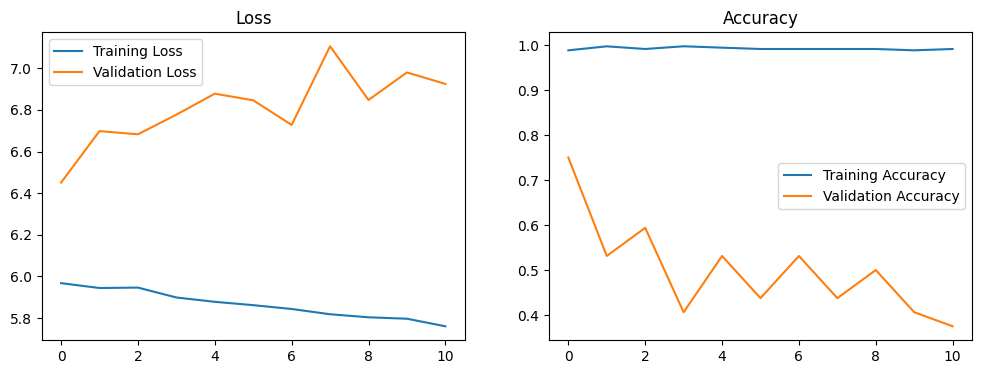

In [17]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

In [12]:
from google.colab import files
uploaded = files.upload()
image_path = next(iter(uploaded.keys()))

Saving A-healthy-Leaf-of-Tulsi-182203-pixahive.webp to A-healthy-Leaf-of-Tulsi-182203-pixahive.webp


In [13]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Set the image path to the image you want to predict

# Load and preprocess the image
test_image = image.load_img(image_path, target_size=(224, 224))
test_image = image.img_to_array(test_image)
test_image = test_image / 255.0  # Rescale the image
test_image = np.expand_dims(test_image, axis=0)

# Predict using the trained model
result = model.predict(test_image)

# Get class indices from the training set
class_indices = train_generator.class_indices

# Interpret the result
if result[0][0] > 0.5:  # Since it's a binary classification with sigmoid activation
    prediction = 'Healthy'
else:
    prediction = 'Diseased'

print(f'The prediction for the image is: {prediction}')

1/1 [==============================] - 1s 956ms/step
The prediction for the image is: Diseased
